# Simple FEM for an elastic plate with a hole

## Create a mesh for the plate with hole

First we need to build the geometry. The shape and mesh is generated with pygmsh, exported to a vtk file that can be visualized with ParaView, and then imported for use in scikit-fem. 

<skfem MeshTri2 object>
  Number of elements: 885
  Number of vertices: 486
  Number of nodes: 1856
  Named boundaries [# facets]: right [11], left [17], bottom [31], top [6], hole [20]


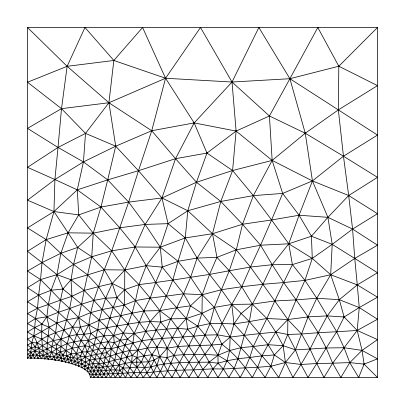

In [204]:
import copy 
import matplotlib.pyplot as plt 
import gmsh
import pygmsh
import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import draw, plot

from global_constants import LBD, MU, L, R, N1, N2

# Ellipse dimensions
Rx = 0.18
# Rx = R * np.sqrt(N1 / N2)
Ry = R**2 / Rx
Rz = 1.0

def mesh_size(dim, tag, x,y,z,lz):
    return 0.01 * np.sqrt(x**2 / Rx**2 + y**2 / Ry**2)
    

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    rectangle = geom.add_rectangle([0.0, 0.0, 0.0], a=L, b=L)
    hole = geom.add_ellipsoid([0, 0, 0.0], [Rx, Ry, Rz])
    geom.boolean_difference(rectangle, hole)
    geom.set_mesh_size_callback(mesh_size)
    m = geom.generate_mesh(order=2)
    m.write("mesh.vtk")

# Convert to scikit-fem mesh
mesh = fem.MeshTri2().load("mesh.vtk")

# Label boundaries
mesh = mesh.with_boundaries(
    {
        "right": lambda x: x[0] == L,
        "left": lambda x: x[0] <= 0.001,
        "bottom": lambda x: x[1] <= 0.001,
        "top": lambda x: x[1] == L,
        "hole": lambda x: (x[0]**2 / Rx**2 + x[1]**2 / Ry**2) <= 1,
    }
)


# Visualize the mesh
draw(mesh, figsize=(5, 5))
print(mesh)

## Create the FEM function space

In [205]:
# Define first order triangles and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementTriP2(), 2)
# Function space
basis = fem.Basis(mesh, element)

basis.get_dofs({"left"}).nodal["u^1"].shape

(18,)

## Material model

A single 2D ply stiffness tensor is given as 

$$
\sigma = 2\mu \nabla^s u + \frac{2\lambda\mu}{\lambda+2\mu} \textrm{tr}(\nabla^s u)I
$$

for plane stress.

In [206]:
def sigma(eps):
    return  2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * eye(trace(eps), 2)

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = \begin{pmatrix}0\\ N_2\end{pmatrix}$$

Right: 

$$ \sigma \cdot n = \begin{pmatrix}N_1\\ 0\end{pmatrix}$$


In [207]:
# Get all degrees of freedom and set appropriate entry to prescribed BCs.
u = basis.zeros()
cons = np.concatenate([basis.get_dofs({"left"}).all(['u^1']),basis.get_dofs({"bottom"}).all(['u^2'])])
# Get remaining degrees of freedom
I = basis.complement_dofs(cons)

# Facet basis for Neumann boundary conditions
right_basis = fem.FacetBasis(mesh, element, facets=mesh.boundaries["right"])
top_basis = fem.FacetBasis(mesh, element, facets=mesh.boundaries["top"])

## Bilinear form of the weak form

$$ \int_\Omega \sigma \left (\nabla^s u \right) : \nabla^s v dV = \int_\Gamma t n \cdot v dA$$

In [208]:
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@fem.LinearForm
def t(v, w):
    return w.traction * dot(w.n, v)

## Assemble and solve

In [209]:
# Assemble matrices
K = fem.asm(k, basis)
T = fem.asm(t, right_basis, traction=N1) + fem.asm(t, top_basis, traction=N2)

# Solve the problem 
u = fem.solve(*fem.condense(K, T, x=u, I=I))

## Postprocessing

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to Displacement.

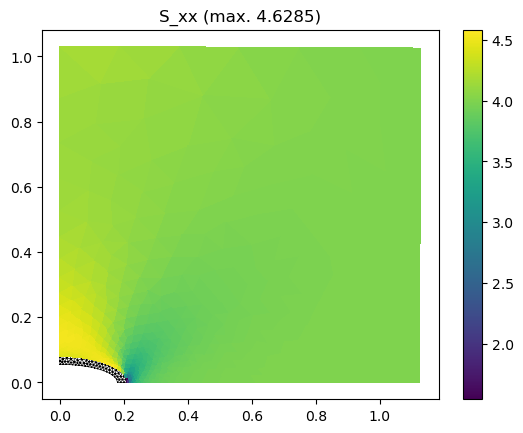

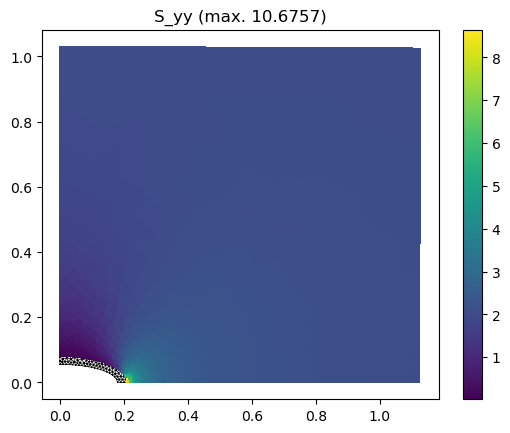

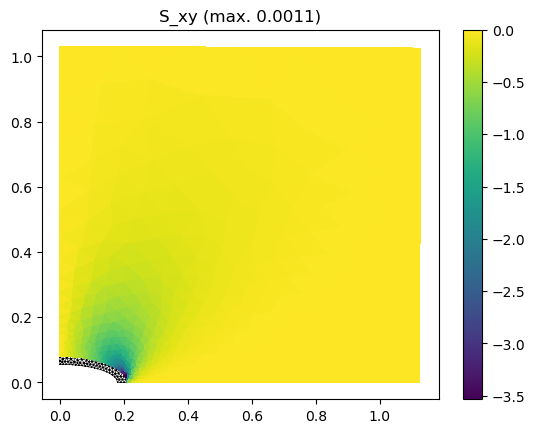

In [210]:
# Get nodal positions 
x = np.zeros_like(u)
dofs0 = list(basis.nodal_dofs[0]) + list(basis.facet_dofs[0]) 
dofs1 = list(basis.nodal_dofs[1]) + list(basis.facet_dofs[1])
x[dofs0] = mesh.doflocs[0]
x[dofs1] = mesh.doflocs[1]

# Compute stress on quadrature points
ui = basis.interpolate(u)
xi = basis.interpolate(x)
E = sym_grad(ui)
S = sigma(E)
Smises = np.sqrt(S[0,0]**2 + S[1,1]**2 - S[0,0]*S[1,1] + 3*S[0,1]**2)

# Save mesh
mesh.save(f"data/result_Rx={Rx:.2f}.vtk", 
            point_data={"Displacement": u.reshape((-1, 2))}, 
            cell_data={"Sxx": [np.mean(S[0,0], axis=-1)], 
                       "Sxy": [np.mean(S[0,1], axis=-1)], 
                       "Syy": [np.mean(S[1,1], axis=-1)],
                       "Exx": [np.mean(E[0,0], axis=-1)], 
                       "Exy": [np.mean(E[0,1], axis=-1)], 
                       "Eyy": [np.mean(E[1,1], axis=-1)],
                       "Smises": [np.mean(Smises, axis=-1)],
                       })

# Save results
inputs = np.stack([xi[0].ravel(), xi[1].ravel(), Rx * np.ones_like(xi[0].ravel())])
np.savetxt(f"data/inputs_Rx={Rx:.2f}.csv", inputs.T, delimiter=",", header="X,Y,R")
outputs = np.stack([S[0,0].ravel(), S[1,1].ravel(), S[0,1].ravel(), Smises.ravel(), 
                    E[0,0].ravel(), E[1,1].ravel(), E[0,1].ravel(), 
                    ui[0].ravel(), ui[1].ravel()])
np.savetxt(f"data/outputs_Rx={Rx:.2f}.csv", outputs.T, delimiter=",", header="Sxx,Syy,Sxy,Smises,Exx,Eyy,Exy,Ux,Uy")

# Compute deformed mesh
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += u[dofs0]
defmesh.doflocs[1] += u[dofs1]

# Plot results
fig, ax = plt.subplots()
draw(mesh, ax=ax, plot_kwargs={"zorder": -1})
plot(defmesh, np.mean(S[0,0], axis=-1),ax=ax, colorbar=True, cmap="viridis")
ax.set_title(f"S_xx (max. {np.max(S[0,0]):.4f})")
plt.show()

fig, ax = plt.subplots()
draw(mesh, ax=ax, plot_kwargs={"zorder": -1})
plot(defmesh, np.mean(S[1,1], axis=-1),ax=ax, colorbar=True, cmap="viridis")
ax.set_title(f"S_yy (max. {np.max(S[1,1]):.4f})")
plt.show()

fig, ax = plt.subplots()
draw(mesh, ax=ax, plot_kwargs={"zorder": -1})
plot(defmesh, np.mean(S[0,1], axis=-1),ax=ax, colorbar=True, cmap="viridis")
ax.set_title(f"S_xy (max. {np.max(S[0,1]):.4f})")
plt.show()


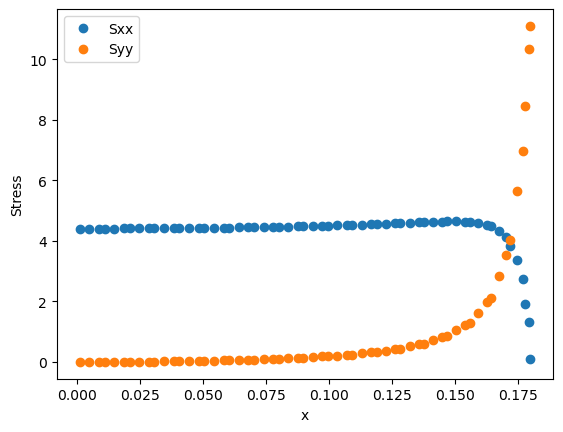

In [211]:
import matplotlib.pyplot as plt
# Evaluate hole facet basis
hole_basis = fem.FacetBasis(mesh, element, facets=mesh.boundaries["hole"])
u_hole = hole_basis.interpolate(u)
x_hole = hole_basis.interpolate(x)
e_hole = sym_grad(u_hole)
s_hole = sigma(e_hole)

hole_data = np.stack([x_hole[0].ravel(), x_hole[1].ravel(), s_hole[0,0].ravel(), s_hole[1,1].ravel()])

np.savetxt(f"data/hole_Rx={Rx:.2f}.csv", hole_data.T, delimiter=",", header="x,y,Sxx,Syy,Sxy")

plt.plot(x_hole[0].ravel(), s_hole[0,0].ravel(), 'o')
plt.plot(x_hole[0].ravel(), s_hole[1,1].ravel(), 'o')
plt.legend(["Sxx", "Syy"])
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()